## Automatisierung des Bereitschaftsdienstplans für Einsatzfahrende mithilfe eines Vorhersagemodells  

Für die Struktur dieser Fallstudie wird den Microsoft Team Data Science Prozess (TDSP) verwendet. Der TDSP empfehlt, dass alle Projekte eine standardisierte Verzeichnisstruktur und Dokumentvorlagen teilen und diese mitsamt allem Code, in einem Version-Control-System wie git gemanaged werden (Jani, 2023). Für diese Fallstudie wird den "Azure-TDSP-ProjectTemplate" Github-Repository gecloned und als Ausgangspunkt benutzt (Azure Github, 2018).

Der TDSP enthält seinen eigenen Projekt-Lebenszyklus mit fünf Hauptphasen, nämlich Geschäftsverständnis, Datenerfassung und -verständnis, Modellierung, Bereitstellung und Kundenakteptanz, die in Abbildung X dargestellt sind.

![TDSP Abbildung](bilder/tdsp-lifecycle2.png)

##### Geschäftsverständnis
Der Zyklus fängt an mit dem Geschäftsverständnis. Die Personalplanung des Berliner Rotkreuz-Rettungsdienstes möchte den Bereitschaftsdienst für Einsatzfahrende effizienter planen. Die zwei Effizienzmaßstäbe sind der Prozentsatz an aktivierten Einsatzfahrenden mit Bereitschaftsdienst an einem bestimmten Tag, der hoch sein sollte (nicht maximiert, was später besprochen werden) und die Anzahl an Tagen mit zu wenig Einsatzfahrenden, die unbedingt vermieden werden sollte. Das Vorhersagemodell, das auf historischen Daten basiert, sollte im Hinblick auf diese Effizienzmaßstäbe besser abschneiden als der bisherige Planungsprozess. Im bisherigen Planungsprozess wurde lediglich konstant 90 Einsatzfahrende pro Tag in Bereitschaft gehalten. Das Problem mit dem bisherigen System ist, dass kurzfristige Krankenstände der Einsatzfahrende oder eine nichtvorhersagte hohe Anzahl an Notrufen zu Kapazitätsenpässen kommen kann. Das Vorhersagemodell muss am 15. jedes Monat den Dienstplan für das nächste Monat ferigstellen, was Vorhersagen für zwischen ungefähr 15 und 45 Tage in der Zukunft benötigt.

Um die zwei Effizienzmaßstäbe konkreter vorstellen zu können, sollte die Standarddarstellung der Daten betrachtet werden, wie in Abbildung X. Im Dataframe ist zu sehen, dass die Spalte *n_sby* die Anzahl an Einsatzfahrende zeigt, die Bereitschaftsdienst haben. Die Spalte *sby-need* - zeigt wie viel von diesen Fahrenden mit Bereitschaftsdienst tatsächlich aktiviert wurden. Die Spalte *dafted* zeigt wie viele Einsatzfahrende, die keine Bereitschaftsdienst hatten, in den Dienst gerufen wurden.

Die zwei Effizienzmaßstäbe bzw. Ziele können hier in Bezug auf den Dataframe in Abbildung X so definiert werden:

Ziel 1: Tage mit zu wenig Bereitschaftsfahrern werden unbedingt vermieden d.h. *dafted*-Spalte hat immer den Wert 0.  
Ziel 2: (zweitrangiges Ziel) Der Prozentsatz von aktivierten Einsatzfahrenden (*sby_need*) sollte hoch sein, ohne das Erreichen von Ziel 1 zu riskieren.

Bevor mit der Analyse angefangen wird, muss die Qualität der Daten überpruft werden. In der Funktion data_prep.csv_to_dataframe(), wird schon eine Reihe von Überprüfungen durchgeführt, die bestätigen, dass der Datensatz ist, wie erwartet wird. Beispielsweise ob die Werte für alle Spalte außer 'data' ganzzahlig sind. Wenn nicht, wird einen ValueError erzeugt. Gleichzeitig wird überprüft, ob es fehlende Daten in den anderen Spalten gibt, d.h. ob es Zellen mit einem NaN-Wert gibt. Wenn schon, wird einen ValueError erzeugt. Die nächste Überprüfung ist ob Daten in der 'data'-Spalte fehlen. Mit der Funktion check_dates(), wird überprüft ob es Einträge für jeden Tag zwischen dem frühesten Datum und dem spätesten gibt.

In [2]:
import Data_AandU.dataPrep as data_prep
df, df_build_notes, summary_list = data_prep.my_df()
print('\n'.join(df_build_notes))

Daten erfolgreich in einen DataFrame umgewandelt
Keine fehlenden Daten in der CSV-Datei
Keine nicht-ganzzahligen Werte in den Spalten 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need', 'dafted'
Alle Spalten ausser 'date' in Integer umgewandelt
Alle Daten in der 'date'-Spalte sind Datetime-Datentyp
Alle Daten zwischen Start- und Enddatum vorhanden


In [3]:
for i in summary_list:
    print(i, '\n')


Dataframe Info: 

                      date       n_sick         calls       n_duty   n_sby  \
count                 1152  1152.000000   1152.000000  1152.000000  1152.0   
mean   2017-10-28 12:00:00    68.808160   7919.531250  1820.572917    90.0   
min    2016-04-01 00:00:00    36.000000   4074.000000  1700.000000    90.0   
25%    2017-01-13 18:00:00    58.000000   6978.000000  1800.000000    90.0   
50%    2017-10-28 12:00:00    68.000000   7932.000000  1800.000000    90.0   
75%    2018-08-12 06:00:00    78.000000   8827.500000  1900.000000    90.0   
max    2019-05-27 00:00:00   119.000000  11850.000000  1900.000000    90.0   
std                    NaN    14.293942   1290.063571    80.086953     0.0   

          sby_need       dafted  
count  1152.000000  1152.000000  
mean     34.718750    16.335938  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%      12.250000     0.000000  
max     555.000000   465.000000  
std   

Es wird überprüft, was für Werte einige Spalten annehmen können. Wir erwarten, dass die Anzahl an Einsatzfahrende im Bereitschaftsdienst konstant 90 ist, was der Fall ist. Es ist auch nutzlich zu wissen, dass die Anzahl an Einsatzfahrende im Dienst nur bisher drei Werten hatte, wie unten gezeigt.

In [4]:
data_prep.describe_data(df)

Werte in der n_sby-Spalte:[90]
Werte in der n_duty-Spalte:[1700 1800 1900]


Im Rahmen dieser Fallstudie wird mögliche Vorhersagen der notwendigen Anzahl an Einsatzfahrenden im Dienst nicht betracht, sondern nur die Anzahl an die im Bereitschaftsdienst.  

Um eine Überblick zu kriegen und mögliche Muster schnell zu erkennen, sollte die Daten in einem Streuungsdiagramm dargestellt werden, wie in Abbildung X. 

##### Saisonale Notruf-Muster 
Wie gesehen werden kann, gibt es auf dem ersten Blick eine klare Muster wobei zwischen Mai und November eher mehr Notrufe gemacht werden im Vergleich zu der Zeit zwischen Mai und November.

##### Algemeine Steigerung an Notrufen
Eine kleine allgemeine Steigerung der Anzahl an Anrufen ist auch deutlich.

##### Höchst- und Tiefstände beim Krankenstand  
Obwohl nicht besonders auffällig, es scheint eine oder mehr Muster in den Krankenständen.

##### Höchst- und Tiefstände beim aktivierten Bereitschaftsdienst
Es gibt klare Tiefstände um Januar herum mit mehr aktivierten Einsatzfahrende aus dem Bereitschaftsdienst zwischen Mai und November.


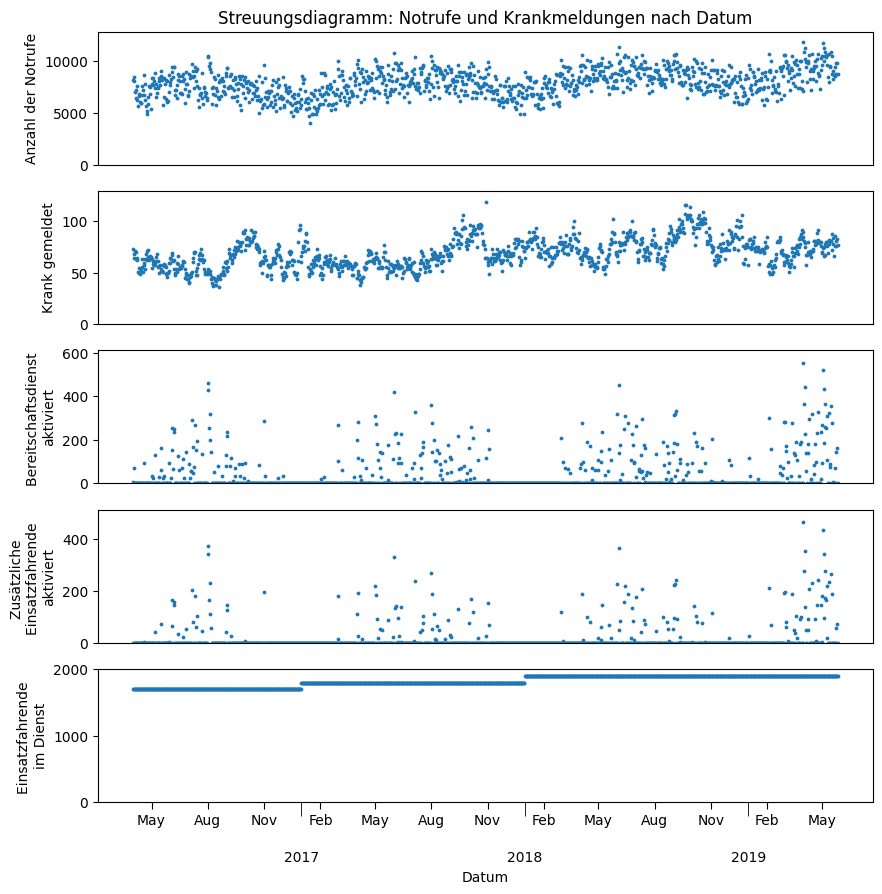

In [5]:
data_prep.overview_scatter(df)

Momentan gibt es vier Spalten, die Informationen über die Nachfrage an Einsatzfahrenden enthalten: n_sick, n_duty, sby_need und dafted. Die Variable "Nachfrage an Einsatzfahrenden" kann in einer vereinfachten Weise dargestellt werden, indem wir folgende kalkulierte Spalte erstellen:  

$\text{n_duty} - \text{n_sick} = \text{tatsächlich im Dienst}$

$\text{sby_need} + \text{tatsächlich im Dienst} = \text{demand}$  

Es gibt einen klaren Mangel in den Daten, der die Vorhersagen für die Anzahl der benötigten Einsatzfahrer erschwert. Wir wissen nur, wie viele Einsatzfahrer aktiviert wurden, solange diese Zahl die Zahl der 'tatsächlich im Dienst' übersteigt. Wir wissen jedoch nicht, wie viele Einsatzfahrer tatsächlich an Tagen eingesetzt werden, an denen die Zahl der 'tatsächlich im Dienst' nicht überschritten wird.

In [6]:
df_2 = data_prep.df_new_columns(df) # Neue Spalten erstellen
df_2

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,month,year,dayofmonth,weekday,weekofyear,dayofyear,season,predict_day,demand
0,2016-04-01,73,8154,1700,90,4,0,4,2016,1,4,13,92,2,2016-03-15,1631.0
1,2016-04-02,64,8526,1700,90,70,0,4,2016,2,5,13,93,2,2016-03-15,1706.0
2,2016-04-03,68,8088,1700,90,0,0,4,2016,3,6,13,94,2,2016-03-15,NaN
3,2016-04-04,71,7044,1700,90,0,0,4,2016,4,0,14,95,2,2016-03-15,NaN
4,2016-04-05,63,7236,1700,90,0,0,4,2016,5,1,14,96,2,2016-03-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2019-05-23,86,8544,1900,90,0,0,5,2019,23,3,21,143,2,2019-04-15,NaN
1148,2019-05-24,81,8814,1900,90,0,0,5,2019,24,4,21,144,2,2019-04-15,NaN
1149,2019-05-25,76,9846,1900,90,146,56,5,2019,25,5,21,145,2,2019-04-15,1970.0
1150,2019-05-26,83,9882,1900,90,160,70,5,2019,26,6,21,146,2,2019-04-15,1977.0


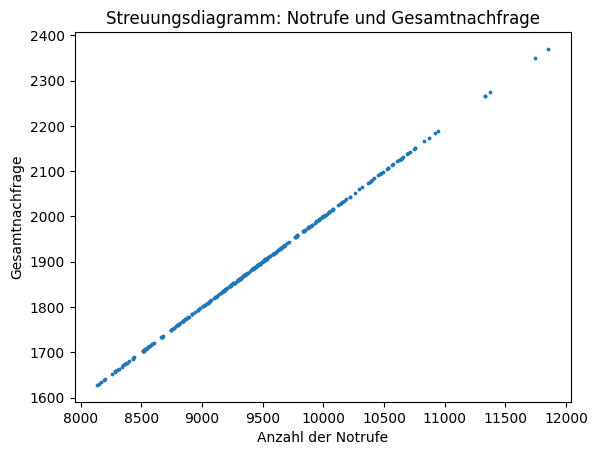

In [7]:
data_prep.sby_needed_vs_calls(df_2)

In [8]:
# Entferne unwichtige Spalten
df_2 = df_2.drop(['n_duty', 'n_sby', 'sby_need', 'dafted', 'predict_day'], axis=1)

In [9]:
reg, reg_score, df_demand_predict = data_prep.notrufe_demand_reg(df_2)
df_demand_predict

,date,n_sick,calls,month,year,dayofmonth,weekday,weekofyear,dayofyear,season,demand,demand_pred
0,2016-04-01,73,8154,4,2016,1,4,13,92,2,1631.0,1631
1,2016-04-02,64,8526,4,2016,2,5,13,93,2,1706.0,1706
2,2016-04-03,68,8088,4,2016,3,6,13,94,2,NaN,1618
3,2016-04-04,71,7044,4,2016,4,0,14,95,2,NaN,1409
4,2016-04-05,63,7236,4,2016,5,1,14,96,2,NaN,1448
...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2019-05-23,86,8544,5,2019,23,3,21,143,2,NaN,1709
1148,2019-05-24,81,8814,5,2019,24,4,21,144,2,NaN,1763
1149,2019-05-25,76,9846,5,2019,25,5,21,145,2,1970.0,1970
1150,2019-05-26,83,9882,5,2019,26,6,21,146,2,1977.0,1977


Aus dem Streuungsdiagramm ist es deutlich klar, dass ein lineares Verhältnis zwischen der Anzahl an Notrufen und der Gesamtnachfrage nach Einsatzfahrenden gibt. Das bedeutet, dass die zwei Hauptfragen mit denen wir uns beschäftigen sollten, sind ob die Anzahl an Anrufen und Krankenstände vorhergesagt kann.

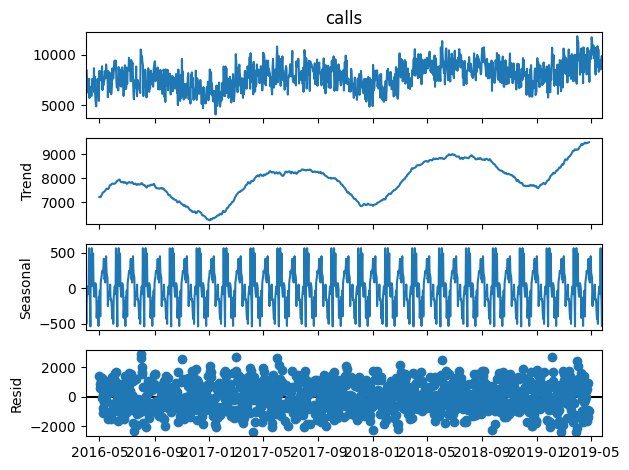

In [10]:
data_prep.seas_decomp(df_demand_predict)

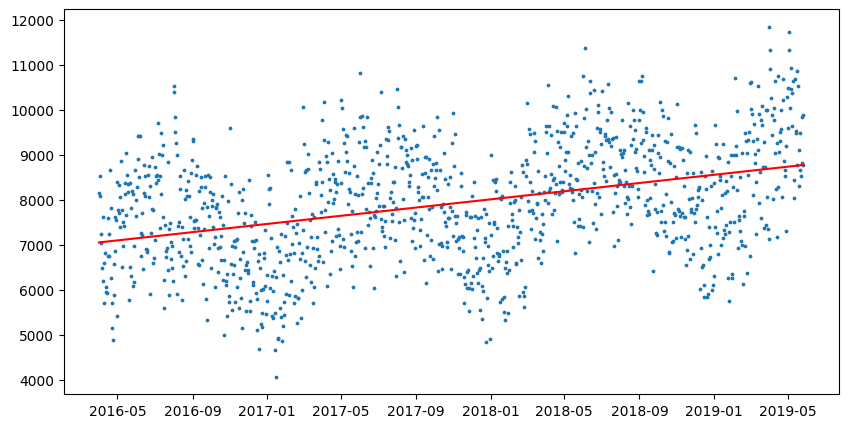

In [11]:
df_demand_predict, ax = data_prep.notruf_reg(df_demand_predict)
import matplotlib.pyplot as plt
plt.show()

In [12]:
df_demand_predict

,date,n_sick,calls,month,year,dayofmonth,weekday,weekofyear,dayofyear,season,demand,demand_pred,calls_pred,calls_diff
0,2016-04-01,73,8154,4,2016,1,4,13,92,2,1631.0,1631,7059,1095
1,2016-04-02,64,8526,4,2016,2,5,13,93,2,1706.0,1706,7060,1466
2,2016-04-03,68,8088,4,2016,3,6,13,94,2,NaN,1618,7062,1026
3,2016-04-04,71,7044,4,2016,4,0,14,95,2,NaN,1409,7063,-19
4,2016-04-05,63,7236,4,2016,5,1,14,96,2,NaN,1448,7065,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2019-05-23,86,8544,5,2019,23,3,21,143,2,NaN,1709,8774,-230
1148,2019-05-24,81,8814,5,2019,24,4,21,144,2,NaN,1763,8776,38
1149,2019-05-25,76,9846,5,2019,25,5,21,145,2,1970.0,1970,8777,1069
1150,2019-05-26,83,9882,5,2019,26,6,21,146,2,1977.0,1977,8779,1103


In [13]:
df_demand_predict = df_demand_predict.drop(['calls','n_sick', 'demand', 'demand_pred', 'calls_pred'], axis=1)

In [14]:
df_demand_predict

,date,month,year,dayofmonth,weekday,weekofyear,dayofyear,season,calls_diff
0,2016-04-01,4,2016,1,4,13,92,2,1095
1,2016-04-02,4,2016,2,5,13,93,2,1466
2,2016-04-03,4,2016,3,6,13,94,2,1026
3,2016-04-04,4,2016,4,0,14,95,2,-19
4,2016-04-05,4,2016,5,1,14,96,2,171
...,...,...,...,...,...,...,...,...,...
1147,2019-05-23,5,2019,23,3,21,143,2,-230
1148,2019-05-24,5,2019,24,4,21,144,2,38
1149,2019-05-25,5,2019,25,5,21,145,2,1069
1150,2019-05-26,5,2019,26,6,21,146,2,1103


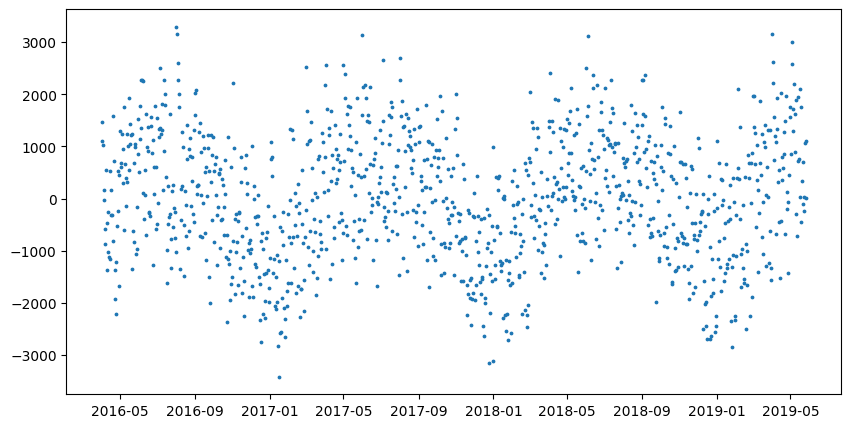

In [15]:
data_prep.notrend_scatter(df_demand_predict)

In [16]:
# Random Forest um die wichtigsten Features zu finden
predictions, feat_gini_importance, results_df = data_prep.my_model_options(df_demand_predict)
print(feat_gini_importance.sort_values(ascending=False))

dayofyear     0.429476
dayofmonth    0.281749
weekday       0.129745
weekofyear    0.110084
month         0.025642
year          0.022135
season        0.001169
dtype: float64


In [17]:
print(results_df)

          mse_rf     r2_rf      mse_adabr  r2_adabr
0  766758.328995  0.379756  718944.694866  0.418433


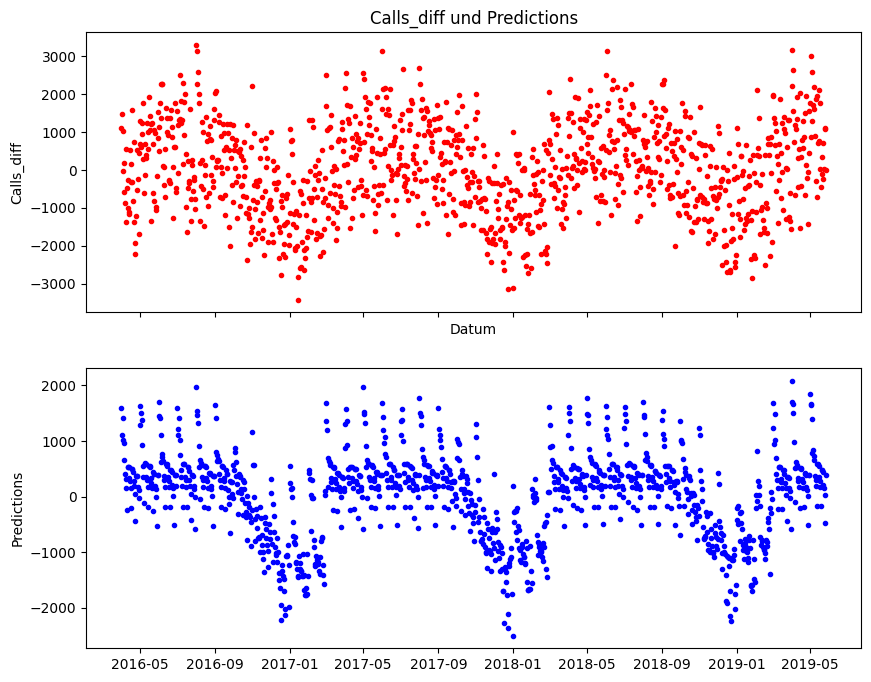

In [18]:
data_prep.plot_train_test(predictions, df_demand_predict)

In [19]:
df_demand_predict = df_demand_predict.drop(['season', 'year', 'month'], axis=1)
predictions, feat_gini_importance, results_df = data_prep.my_model_options(df_demand_predict)
print(feat_gini_importance.sort_values(ascending=False))

AttributeError: module 'Data_AandU.dataPrep' has no attribute 'my_random_forest'

In [ ]:
print(mse, r2)

In [ ]:
data_prep.plot_train_test(predictions, df_demand_predict)

##### Datenerfassung und -verständnis  




#### Processbeschreibung  

#### Beschreibung der relevanten Rollen  

#### Sammlung von Hilfsmitteln und Softwaretools  


Archiv

#### Data-Science-Lebenszyklus
- Geschäftsverständnis  
- Modellierung  
    - Merkmalsgenerierung
    - Training
    - Evaluierung
- Datenerfassung, und -verständnis  
    - Datenquelle
    
- Bereitstellung
    - Speicherung des Modells  
    - Webservice  
    - Anwendungen